<a href="https://colab.research.google.com/github/Masao-Taketani/various_GANs_analysis/blob/master/cyclegan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
dataset, metadata = tfds.load("cycle_gan/horse2zebra",
                              with_info=True,
                              as_supervised=True)

train_horses, train_zebras = dataset["trainA"], dataset["trainB"]
test_horses, test_zebras = dataset["testA"], dataset["testB"]

In [12]:
def count_size(dataset):
  ct = 0
  for _ in dataset.as_numpy_iterator():
    ct += 1

  return ct

def random_crop(img):
  cropped_img = tf.image.random_crop(img,
                                     size=[HEIGHT, WIDTH, 3])
  
  return cropped_img

# to normalize an image to [-1, 1]
def normalize(img):
  img = tf.cast(img, tf.float32)
  img = (img / 127.5) - 1
  return img

def random_jitter(img):
  # to resize an image to 286 x 286 x 3
  img = tf.image.resize(img,
                        [286, 286],
                        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  # to randomly crop an image to 256 x 256 x 3
  img = random_crop(img)
  # to randomly mirror an image
  img = tf.image.random_flip_left_right(img)

  return img

def preprocess_img_train(img, label):
  img = random_jitter(img)
  img = normalize(img)

  return img

def preprocess_img_test(img, label):
  img = normalize(img)

  return img

def normalize_to_zero_one(img):
  return img * 0.5 + 0.5

def plot_sample_img(img, kind):
  jittered_img = random_jitter(img)
  plt.subplot(121)
  plt.title(kind)
  plt.imshow(normalize_to_zero_one(img))

  plt.subplot(122)
  plt.title("{} with random jitter".format(kind))
  plt.imshow(normalize_to_zero_one(jittered_img))

In [5]:
BUFFER_SIZE = count_size(train_horses)
BATCH_SIZE = 1
WIDTH = 256
HEIGHT = 256

In [6]:
train_horses = train_horses.map(preprocess_img_train,
                                num_parallel_calls=AUTOTUNE).cache().shuffle(
                                    BUFFER_SIZE).batch(BATCH_SIZE)
train_zebras = train_zebras.map(preprocess_img_train,
                                num_parallel_calls=AUTOTUNE).cache().shuffle(
                                    BUFFER_SIZE).batch(BATCH_SIZE)
test_horses = test_horses.map(preprocess_img_test,
                              num_parallel_calls=AUTOTUNE).cache().shuffle(
                                  BUFFER_SIZE).batch(BATCH_SIZE)
test_zebras = test_zebras.map(preprocess_img_test,
                              num_parallel_calls=AUTOTUNE).cache().shuffle(
                                  BUFFER_SIZE).batch(BATCH_SIZE)

In [7]:
sample_horse = next(iter(train_horses))
sample_zebra = next(iter(train_zebras))

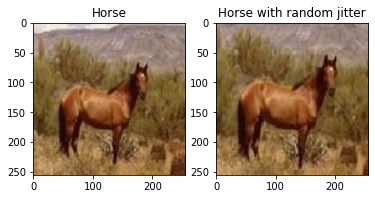

In [13]:
plot_sample_img(sample_horse[0], "Horse")

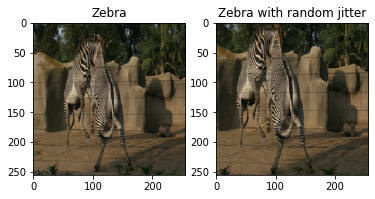

In [14]:
plot_sample_img(sample_zebra[0], "Zebra")